In [1]:
import os
from itertools import product

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import pecanpy as pp
import scipy
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import auc, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPClassifier
import torch
import torch.nn as nn
from umap import UMAP

In [2]:
np.random.seed(42)

# Dataset

In [3]:
loaded_data = {}
def get_data(cell_type):
    # Get graph
    data_folder = './data/training_matrices_DGL/'
    if cell_type in loaded_data:
        mat = loaded_data[cell_type]
    else:
        mat = pd.read_csv(data_folder + f'{cell_type}.feat.mat', index_col=0, sep='\t')
        loaded_data[cell_type] = mat
    genes = np.array(mat.columns)
    assert (genes == np.array(mat.index)).all()

    # Get labels
    meta = pd.read_csv(data_folder + 'training_labels.txt', index_col=0, sep='\t')
    labels = meta.values[:, 0]
    labels = np.array([str(meta.loc[g]['label']) if g in meta.index else 'unknown' for g in genes])

    return mat.to_numpy(), labels, genes

# Model

In [4]:
cell_types = np.array([f[:-9] for f in os.listdir('./data/training_matrices_DGL') if '.mat' in f])
cell_type = cell_types[0]
for ct in cell_types:
    print(ct) if ct != cell_type else print(f'--{ct}')

--Astrocyte
Endothelial
GABAergic_neuron
GABAergic_PVALB_interneuron
GABAergic_SST_interneuron
GABAergic_VIP_interneuron
Glutamatergic_neuron
Microglia
Mural
Oligodendrocyte
OPC


In [5]:
print(f'Loading {cell_type} data...')
# Load data
data, labels, genes = get_data(cell_type)

print('Constructing graph...')
# Construct graph
g = pp.graph.AdjlstGraph()
for i in range(data.shape[0]):
    for j in range(i+1, data.shape[0]):
        weight = float(data[i][j])
        if weight != 0:
            g.add_edge(genes[i], genes[j], weight=weight, directed=False)
g.save('_elist.edg')

Loading Astrocyte data...
Constructing graph...


In [6]:
print('Reading graph...')
# Load as precomp
g = pp.pecanpy.SparseOTF(p=1, q=1, workers=4, verbose=True)
g.read_edg('_elist.edg', weighted=True, directed=False)
# g.preprocess_transition_probs()

Reading graph...


In [7]:
dim, num_walks, walk_length = 32, 10, 20
fname = f'embeddings-{cell_type}-{dim}-{num_walks}-{walk_length}.npy'
if os.path.exists(fname):
    print('Loading embeddings...')
    # Load embeddings
    emb = np.load(fname)
else:
    print('Generating embeddings...')
    # Generate embeddings
    emb = g.embed(dim=dim, num_walks=num_walks, walk_length=walk_length)
    np.save(fname, emb)

# Chart connected subgraph
surviving_nodes = [np.argwhere(genes==gn).flatten()[0] for gn in g.nodes]

Generating embeddings...


  0%|                                                                                        | 0/108020 [00:00…

In [8]:
np.random.seed(42)

print('Splitting data...')
# Generate train_idx
train_frac = .8
train_idx = np.random.choice(emb.shape[0], int(train_frac * emb.shape[0]), replace=False)
train_idx = np.intersect1d(train_idx, np.array(list( set(list(range(emb.shape[0]))) - set(list(np.argwhere(labels[surviving_nodes]=='unknown').flatten())) )))
eval_idx = np.array(list(set(list(range(emb.shape[0]))) - set(train_idx)))

Splitting data...


In [9]:
class Basic(nn.Module):
    def __init__(self, input_dim, hidden_dim=None):
        super().__init__()
        
        self.input_dim = input_dim
        hidden_dim = hidden_dim if hidden_dim is not None else int(2*input_dim)
        self.hidden_dim = hidden_dim
        
        self.encode = nn.Sequential(
            # nn.Dropout(.6),
            
            nn.Linear(input_dim, hidden_dim),
            nn.Dropout(.6),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(),
            
            nn.Linear(hidden_dim, hidden_dim),
            nn.Dropout(.6),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(),
        )
        self.decode = nn.Sequential(
            nn.Linear(hidden_dim, 1),
            # nn.BatchNorm1d(1),
            nn.Sigmoid(),
        )
        self.main = nn.Sequential(
            self.encode,
            self.decode,
        )
        
    def forward(self, X):
        return self.main(X)

class Soft(nn.Module):
    def __init__(self, input_dim, hidden_dim=None):
        super().__init__()
        
        self.input_dim = input_dim
        hidden_dim = hidden_dim if hidden_dim is not None else int(input_dim)
        self.hidden_dim = hidden_dim
        
        self.main = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            # nn.Dropout(.8),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            
            nn.Linear(hidden_dim, 2),
            nn.BatchNorm1d(2),
            nn.Softmax(-1),
        )
        
    def forward(self, X):
        return self.main(X)[:, [1]]

In [10]:
np.random.seed(42)
torch.manual_seed(42)

print('Creating classification model...')
# Balanced train
batch_size = 512
min_epochs = 0
max_epochs = 10_001
max_lapses = 300

mlp = Basic(emb.shape[1])
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-5)
criterion = nn.BCELoss()
# criterion = nn.MSELoss()
best_loss = torch.inf; lapses = 0
for epoch in range(max_epochs):
    epoch_loss = 0
    
    mlp.train()
    for batch in range(emb.shape[0] // batch_size):
        # Equal batches
        seg_size = int(batch_size / 2)
        ad_batch_idx = np.random.choice(
            np.intersect1d(train_idx, np.argwhere(labels[surviving_nodes]=='AD').squeeze()),
            seg_size,
            replace=True)
        notad_batch_idx = np.random.choice(
            np.intersect1d(train_idx, np.argwhere(labels[surviving_nodes]=='notAD').squeeze()),
            seg_size,
            replace=True)
        batch_idx = np.concatenate([ad_batch_idx, notad_batch_idx])
        true = torch.cat([torch.ones((seg_size, 1)), torch.zeros((seg_size, 1))])
        
        # Representative batches
        # batch_idx = np.random.choice(train_idx, batch_size, replace=True)
        # true = torch.Tensor(labels[surviving_nodes][batch_idx] == 'AD').unsqueeze(1)

        logits = mlp(torch.Tensor(emb[batch_idx]))
        loss = criterion(logits, true)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach()
    epoch_loss = epoch_loss / (emb.shape[0] // batch_size)
    
    # Evaluation loss
    mlp.eval()
    logits = mlp(torch.Tensor(emb[eval_idx])).detach().squeeze()
    trans = {'AD': 1, 'notAD': 0, 'unknown': 2}
    trans_inv = {v: k for k, v in trans.items()}
    true = torch.Tensor([trans[l] for l in labels[surviving_nodes][eval_idx]])
    eval_loss = criterion(logits[np.argwhere(true!=2).squeeze()], true[np.argwhere(true!=2).squeeze()]).detach()
    
    # CLI
    if epoch % 25 == 0:
        print(f'Epoch {epoch}:\tTrain_Loss {float(epoch_loss):.3f},\tEval_Loss {float(eval_loss):.3f}')
    
    # Early stopping
    if epoch >= min_epochs:
        lapses += 1
    if eval_loss < best_loss:
        best_loss = eval_loss
        lapses = 0
    if lapses >= max_lapses:
        print(f'Epoch {epoch}:\tTrain_Loss {float(epoch_loss):.3f},\tEval_Loss {float(eval_loss):.3f}')
        print('Stopped!')
        break
mlp.eval();

Creating classification model...
Epoch 0:	Train_Loss 0.710,	Eval_Loss 0.741
Epoch 25:	Train_Loss 0.699,	Eval_Loss 0.689
Epoch 50:	Train_Loss 0.696,	Eval_Loss 0.752
Epoch 75:	Train_Loss 0.691,	Eval_Loss 0.763
Epoch 100:	Train_Loss 0.691,	Eval_Loss 0.744
Epoch 125:	Train_Loss 0.686,	Eval_Loss 0.728
Epoch 150:	Train_Loss 0.687,	Eval_Loss 0.714
Epoch 175:	Train_Loss 0.682,	Eval_Loss 0.699
Epoch 200:	Train_Loss 0.675,	Eval_Loss 0.696
Epoch 225:	Train_Loss 0.674,	Eval_Loss 0.691
Epoch 250:	Train_Loss 0.664,	Eval_Loss 0.676
Epoch 275:	Train_Loss 0.662,	Eval_Loss 0.648
Epoch 300:	Train_Loss 0.652,	Eval_Loss 0.654
Epoch 325:	Train_Loss 0.642,	Eval_Loss 0.617
Epoch 350:	Train_Loss 0.641,	Eval_Loss 0.636
Epoch 375:	Train_Loss 0.630,	Eval_Loss 0.651
Epoch 400:	Train_Loss 0.621,	Eval_Loss 0.625
Epoch 425:	Train_Loss 0.622,	Eval_Loss 0.546
Epoch 450:	Train_Loss 0.615,	Eval_Loss 0.545
Epoch 475:	Train_Loss 0.613,	Eval_Loss 0.580
Epoch 500:	Train_Loss 0.605,	Eval_Loss 0.568
Epoch 525:	Train_Loss 0.588

# Evaluation

In [11]:
threshold = .75

print('Evaluating performance...')
print('Train')
## Train
# Perform prediction
logits = mlp(torch.Tensor(emb[train_idx])).detach().squeeze()
trans = {'AD': 1, 'notAD': 0, 'unknown': 2}
trans_inv = {v: k for k, v in trans.items()}
true = torch.Tensor([trans[l] for l in labels[surviving_nodes][train_idx]]).long()

# Get confusion
conf = confusion_matrix(true, 1*(logits > threshold))
print('T\P\t' + '\t'.join([trans_inv[i] for i in range(len(trans_inv)-1)]))
for i, row in enumerate(conf):
    print(trans_inv[i] + '\t' + '\t'.join([str(e) for e in row]))

# Other statistics
fpr, tpr, thresholds = roc_curve(true[np.argwhere(true!=2).squeeze()], logits[np.argwhere(true!=2).squeeze()])
print(f'AUROC:\t{auc(fpr, tpr):.4f}')
prec, rec, thresholds = precision_recall_curve(true[np.argwhere(true!=2).squeeze()], logits[np.argwhere(true!=2).squeeze()])
print(f'AUPRC:\t{auc(rec, prec):.4f}')
print()

print('Eval')
## Eval
# Perform prediction
logits = mlp(torch.Tensor(emb[eval_idx])).detach().squeeze()
trans = {'AD': 1, 'notAD': 0, 'unknown': 2}
trans_inv = {v: k for k, v in trans.items()}
true = torch.Tensor([trans[l] for l in labels[surviving_nodes][eval_idx]]).long()

# Get confusion
conf = confusion_matrix(true, 1*(logits > threshold))
print('T\P\t' + '\t'.join([trans_inv[i] for i in range(len(trans_inv))]))
for i, row in enumerate(conf):
    print(trans_inv[i] + '\t' + '\t'.join([str(e) for e in row]))

# Other statistics
fpr, tpr, thresholds = roc_curve(true[np.argwhere(true!=2).squeeze()], logits[np.argwhere(true!=2).squeeze()])
print(f'AUROC:\t{auc(fpr, tpr):.4f}')
prec, rec, thresholds = precision_recall_curve(true[np.argwhere(true!=2).squeeze()], logits[np.argwhere(true!=2).squeeze()])
print(f'AUPRC:\t{auc(rec, prec):.4f}')
print()
    
print('Recording predictions...')
# Write predicted AD to file (only unknown genes)
unk_idx = np.argwhere(labels[surviving_nodes][eval_idx]=='unknown').squeeze()
np.savetxt('AD.txt', genes[surviving_nodes][eval_idx][np.intersect1d(unk_idx, np.argwhere(logits > .8).squeeze())], fmt='%s')

Evaluating performance...
Train
T\P	notAD	AD
notAD	2213	179
AD	59	39
AUROC:	0.8185
AUPRC:	0.1462

Eval
T\P	notAD	AD	unknown
notAD	566	48	0
AD	22	1	0
unknown	7075	600	0
AUROC:	0.5921
AUPRC:	0.0885

Recording predictions...


# Visualization

In [12]:
style='white'
sns.set(style=style)
plt.rcParams.update({'font.weight': 'normal',
                     'font.size': 18,
                     'axes.titlesize': 'large',
                     'axes.labelsize': 'large',
                     'xtick.labelsize': 'small',
                     'ytick.labelsize': 'small'})
sns.set_palette('husl', len(np.unique(labels)))

In [13]:
name_map = {'AD': 'AD', 'notAD': 'Not AD', 'unknown': 'Unknown'}
color_map = {'AD': 'red', 'notAD': 'blue', 'unknown': 'black'}
z_map = {'AD': 2, 'notAD': 1, 'unknown': 0}
s_map = {'AD': 10., 'notAD': 1., 'unknown': .05}

In [14]:
%%capture
from matplotlib.lines import Line2D

# Legend
legend = [
    Line2D([], [], color=(1, 1, 1, 0), markerfacecolor=color_map[l], marker='o', markersize=10)
    for l in np.unique(labels[surviving_nodes])]
legend_names = [name_map[l] for l in np.unique(labels[surviving_nodes])]

# Plot legend
fig, ax = plt.subplots()
legend = ax.legend(legend, legend_names, loc='center', frameon=False, ncol=len(legend)//1)
legend.figure.canvas.draw()
bbox = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
plt.axis('off')
plt.tight_layout()
plt.savefig('results/fig_legend.png', bbox_inches=bbox, dpi=300)

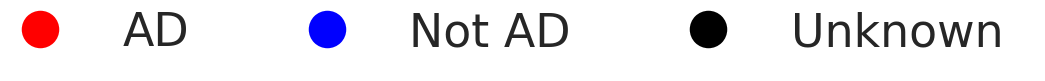

In [15]:
from IPython.display import display, Image
display( Image(filename='results/fig_legend.png', width=800) )

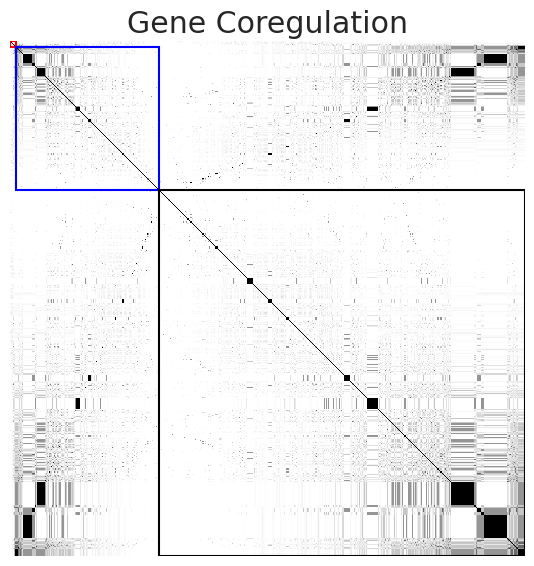

In [16]:
# Get data
adj_matrix = data[surviving_nodes, :][:, surviving_nodes]
block_type = ('AD', 'notAD', 'unknown')
block_list = [np.argwhere(labels[surviving_nodes]==l) for l in block_type]
block_colors = [color_map[l] for l in block_type]

# Sort data
idx_list = list(range(adj_matrix.shape[1]))
order_ad = [0 if labels[idx]=='AD' else (1 if labels[idx]=='notAD' else 2) for idx in idx_list]
order_sum = -adj_matrix.sum(axis=1)
order_sum = [os if order_ad[idx]%2!=0 else -os for idx, os in enumerate(order_sum)]  # Smooth visual
order = list(np.stack([idx_list, order_ad, order_sum]).T)
import operator
order.sort(key=operator.itemgetter(1,2))
order = np.array(order)[:, 0].astype(int)

# Plot data
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
plt.imshow(adj_matrix[order, :][:, order], cmap='Greys', interpolation='none')

# Plot boxes
# http://sociograph.blogspot.com/2012/11/visualizing-adjacency-matrices-in-python.html
from matplotlib import patches
current_idx = 0
for block, color in zip(block_list, block_colors):
    ax.add_patch(patches.Rectangle((current_idx, current_idx),
                                   block.shape[0],
                                   block.shape[0],
                                   facecolor='none',
                                   edgecolor=color,
                                   linewidth=1.5))
    current_idx += block.shape[0]
ax.set_xticks([])
ax.set_yticks([])
sns.despine(left=True, bottom=True)
plt.title('Gene Coregulation')
plt.tight_layout()
plt.savefig('results/fig_data.png', dpi=300)

In [17]:
def display_umap(transformed_data, labels):
    for l in np.unique(labels):
        plt.scatter(
            *transformed_data[labels==l, :].T,
            c=color_map[l],
            zorder=z_map[l],
            s=s_map[l],
            label=l)
    plt.title('Embeddings')
    sns.despine(left=True, bottom=True)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

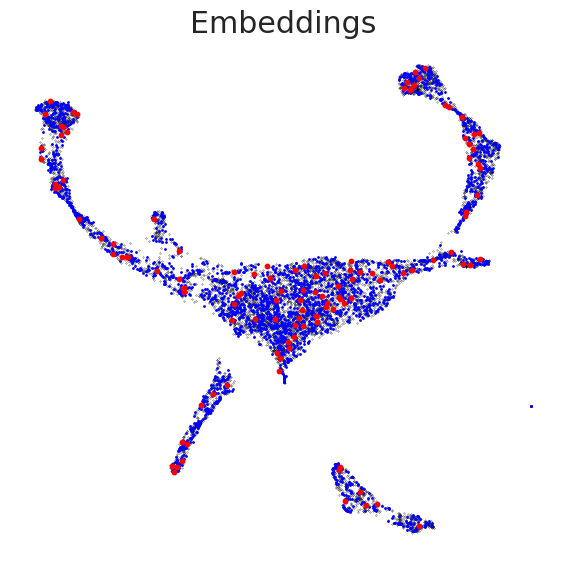

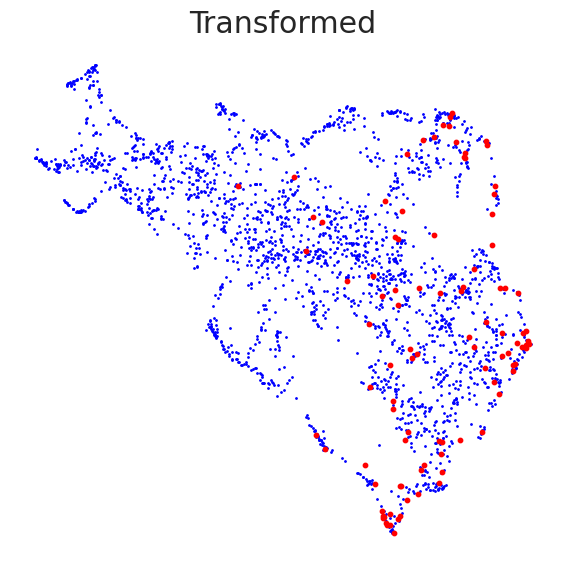

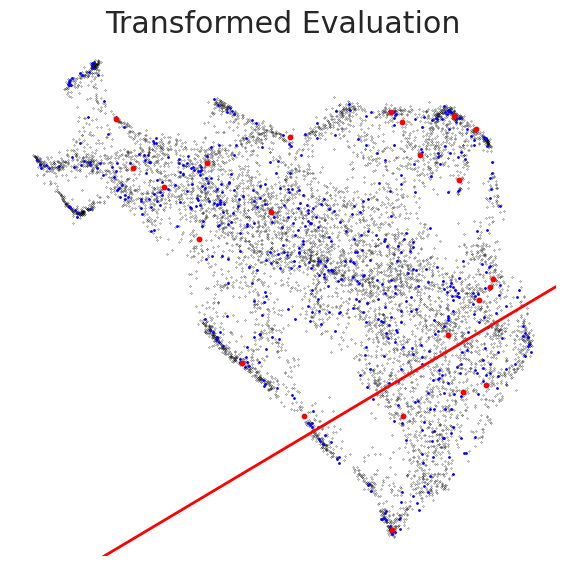

In [18]:
# Embeddings
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
transformed_data = UMAP(n_components=2, random_state=42).fit_transform(emb)
display_umap(transformed_data, labels[surviving_nodes])
plt.title('Embeddings')
plt.tight_layout()
plt.savefig('results/fig_embedding.png', dpi=300)

# Umap for training-eval transform
umap = UMAP(n_components=2, random_state=42)
umap.fit(mlp.encode(torch.Tensor(emb[train_idx])).detach().numpy())

# Training plot
fig, axs = plt.subplots(1, 1, figsize=(6, 6))
transformed_data = umap.transform(mlp.encode(torch.Tensor(emb[train_idx])).detach().numpy())
display_umap(transformed_data, labels[surviving_nodes][train_idx])
plt.title('Transformed')
plt.tight_layout()
plt.savefig('results/fig_transformed.png', dpi=300)
xlim, ylim = plt.xlim(), plt.ylim()

# Evaluation plot
fig, axs = plt.subplots(1, 1, figsize=(6, 6))
transformed_data = umap.transform(mlp.encode(torch.Tensor(emb[eval_idx])).detach().numpy())
display_umap(transformed_data, labels[surviving_nodes][eval_idx])
plt.plot(np.array(xlim), .4*np.array(xlim)+0, '-', color='red', linewidth=2)
plt.xlim(xlim)
plt.ylim(ylim)
plt.title('Transformed Evaluation')
plt.tight_layout()
plt.savefig('results/fig_transformed_eval.png', dpi=300)